$
\huge{
\textbf{
BaSTI Isochrones Only Notebook
}
}
$

In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, vstack, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

import glob

In [2]:
##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

import pandas as pd #needed for readbasti
def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        #lggcol = Column(np.log10(((6.67259*(10**-8)*1.989*10**33)/(6.96*10**10)**2)*(10**df['MFIN'])*(10**(df['LOGT']**4))/(5780)**4/(10**df['LOGL'])),name='LOGG')
        #table_out.add_column(lggcol)
    return table_out


#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [7]:
#create .dat files for the BaSTI isochrones along with monarch and astropy table
#import xarray as xr
files = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.isc_2mass')

noperiod = []
for i in range(len(files)):
    #new_files.append('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/'+files[i])
    splt = files[i].split('.')
    noperiod.append(splt[0]+splt[1])

for j in range(len(files)):
    tab = readbasti(files[j])
    tab.write('{}.dat'.format(noperiod[j]),format='csv',overwrite=True)
    
datfiles = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.dat')
output_file = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat'
for i, fname in enumerate(datfiles):
    df = pd.read_csv(fname)
    if i==0:
        df.to_csv(output_file, index = False)
    else:
        df.to_csv(output_file, mode = 'a+', index = False, header = False)

In [8]:
#Read in dat file
basti = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat')
tbasti = Table.from_pandas(basti)

In [9]:
set(tbasti['FEH'])

{-2.6,
 -2.5,
 -2.4,
 -2.3,
 -2.2,
 -2.1,
 -2.0,
 -1.9,
 -1.8,
 -1.7,
 -1.6,
 -1.5,
 -1.4,
 -1.3,
 -1.2,
 -1.1,
 -1.0,
 -0.9,
 -0.8,
 -0.7,
 -0.6,
 -0.501,
 -0.4,
 -0.3,
 -0.2,
 -0.102,
 0.002,
 0.099}

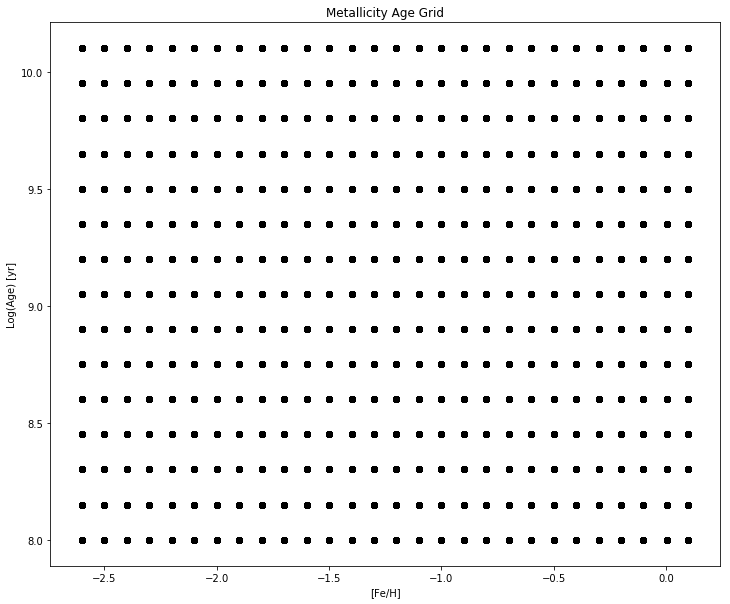

In [10]:
#Metallicity Age
plt.figure(figsize=[12,10])
plt.scatter(basti['FEH'],basti['LOGAGE'],c='k')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('BaSTIgrid.pdf',bbox_inches='tight')
plt.show()

In [8]:
basti.columns

Index(['MINI', 'MFIN', 'LOGL', 'LOGT', 'JMAG', 'HMAG', 'KMAG', 'FEH',
       'LOGAGE'],
      dtype='object')

In [11]:
plt.figure(figsize=[12,10])
plt.scatter(basti['JMAG']-basti['KMAG'],basti['HMAG'],c=basti['FEH'],cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

KeyboardInterrupt: 

In [54]:
# lum = np.reciprocal(10**basti['LOGL'])

# logg = np.log10(lum)+np.log10(basti['MINI'])+4*basti['LOGT']+np.log((6.67259*10**(-8)*1.99*10**33)/(6.96*10**10)**2)

In [12]:
mas = tbasti['MFIN']*(1.99*10**33)
tem = 10**tbasti['LOGT']
lum = (10**tbasti['LOGL'])*(3.9*10**33)

logg = np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum))

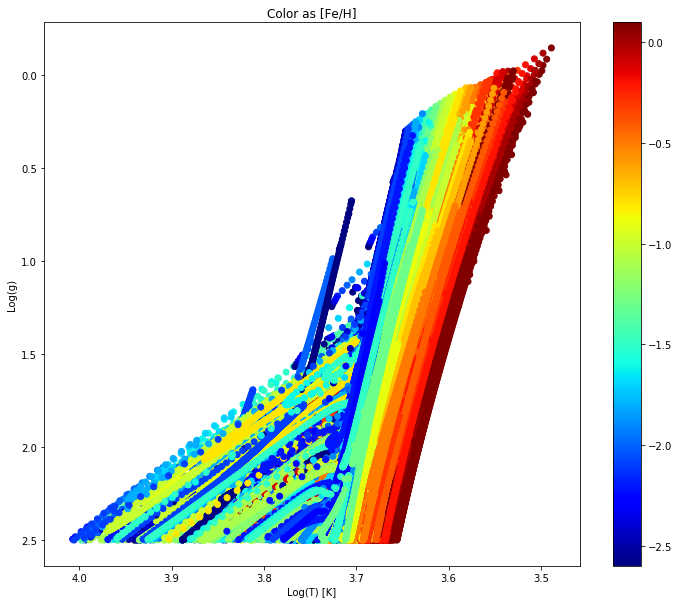

In [14]:
rgb = np.where(logg<2.5)

plt.figure(figsize=[12,10])
plt.scatter(tbasti['LOGT'][rgb],logg[rgb],c=tbasti['FEH'][rgb],cmap='jet')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'Log(T) [K]')
plt.ylabel(r'Log(g)')
plt.title(r'Color as [Fe/H]')
plt.show()

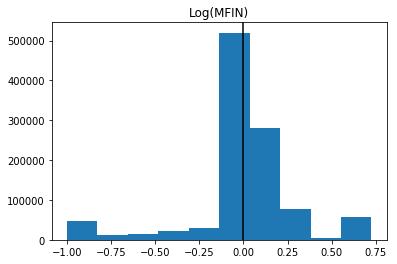

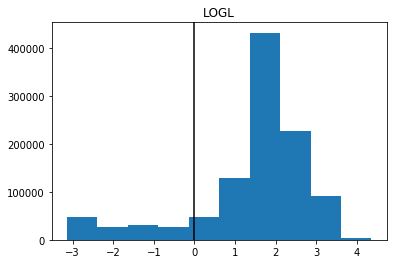

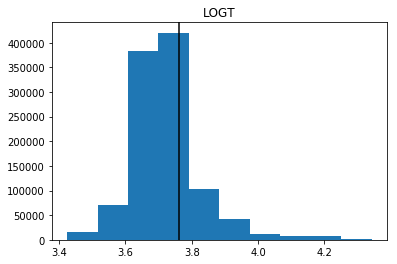

In [42]:
plt.hist(np.log10(basti['MFIN']))
plt.title(r'Log(MFIN)')
plt.axvline(0,c='k')
plt.show()

plt.hist(basti['LOGL'])
plt.title(r'LOGL')
plt.axvline(0,c='k')
plt.show()

plt.hist(basti['LOGT'])
plt.title(r'LOGT')
plt.axvline(np.log10(5780),c='k')
plt.show()

array([ True,  True,  True, ..., False, False, False])